# Лабораторная работа 1. Градиентный спуск и Линейная Рергрессия. (10 баллов)

В этой лабораторной работе вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Лабораторная работа оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [1540]:
from typing import List, Iterable
from sklearn.impute import SimpleImputer

import numpy as np
import matplotlib.pyplot as plt

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [1541]:
import abc

class BaseLoss(abc.ABC):
    """Базовый класс лосса"""
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [1542]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        # -- YOUR CODE HERE --
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        y_pred = np.dot(X, w) # предсказываем y перемножая X на веса
        loss = np.mean((y_pred-y)**2) # считаем ошибку
        return loss
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE --
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        y_pred = np.dot(X, w)
        X = np.transpose(X)
        grad = 2/(y.size)*np.dot(X,(y_pred-y)) # считаем градиент нашего функционала 
        return grad
        

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [1543]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483., 
                                                      1199584., 1208685., 1217786., 1226887., 
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [1545]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    # -- YOUR CODE HERE --
        
    new_w = w_init
    w_list = [] # список где будут хранится все наши веса
   
    for i in range(n_iterations):
        previous_w = new_w
        gradient = loss.calc_grad(X, y, previous_w) # cчитаем градиент
        new_w = previous_w - lr*gradient # обновляем веса
        w_list.append(new_w)
     
        
    return np.asarray(w_list)

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [1546]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)
# print(w_true.shape)
# print(w_init.shape)

(300, 2)
(300,)


In [1547]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

155.26258214352075
0.8670644395649493


In [1548]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend='both')

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

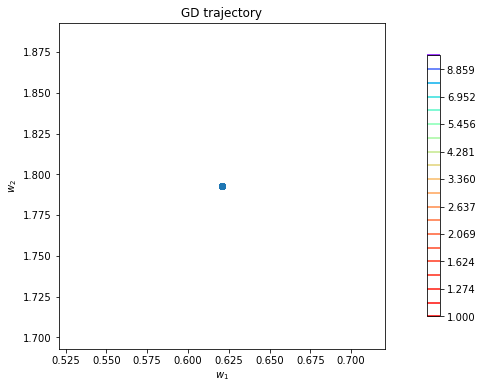

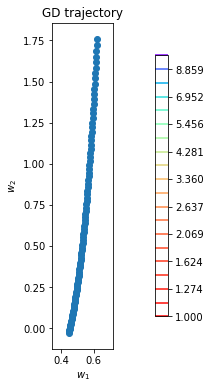

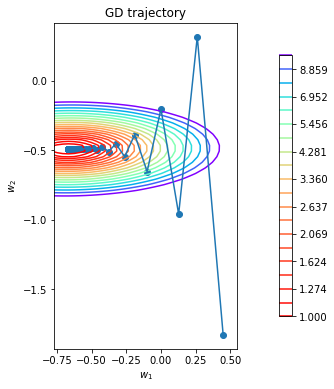

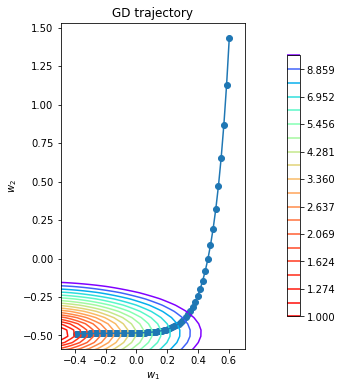

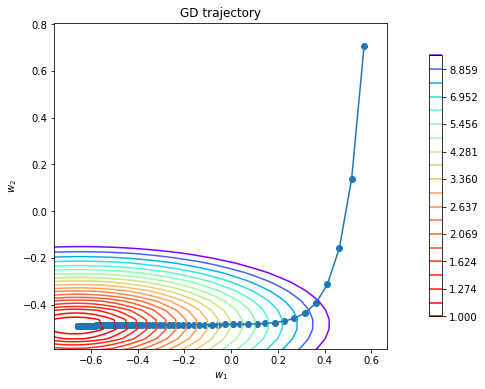

In [1549]:
# -- YOUR CODE HERE --

plot_gd(gradient_descent(w_init, X, y, loss, 0.0, 100),X,y,loss) # никак не будет меняться
plot_gd(gradient_descent(w_init, X, y, loss, 0.0001, 100),X,y,loss) 
plot_gd(gradient_descent(w_init, X, y, loss, 0.01, 100),X,y,loss)
plot_gd(gradient_descent(w_init, X, y, loss, 0.001, 100),X,y,loss)
plot_gd(gradient_descent(w_init, X, y, loss, 0.003, 100),X,y,loss)


# если взять слишком маленький то мы можем просто не дойди до минимума
# в промещутке от 0.0001 до 0.1, чем меньше шаг, тем более плавнее сходится к точке минимума 

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [1560]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    # -- YOUR CODE HERE --    
    
    
    new_w = w_init
    w_list = [] # список где будут хранится все наши веса
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False) # генерируем случ. индексы
        batch = X[batch_indices] # делаем выборку по наши индексам
        previous_w = new_w
        gradient = loss.calc_grad(batch, y[batch_indices], previous_w) # считаем градиент
        new_w = previous_w - lr*gradient # обновляем веса
        w_list.append(new_w)
        
    return np.asarray(w_list)

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

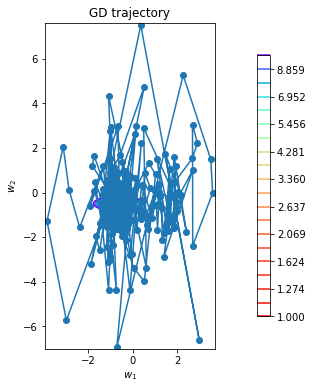

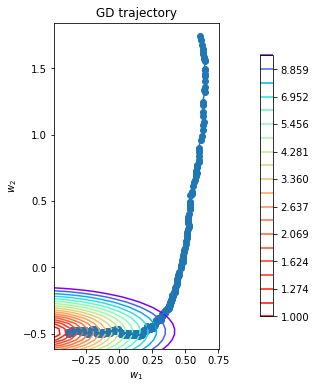

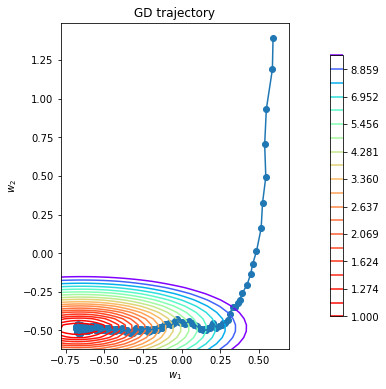

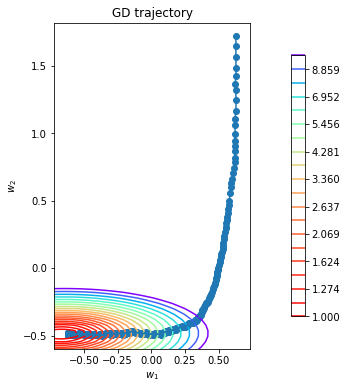

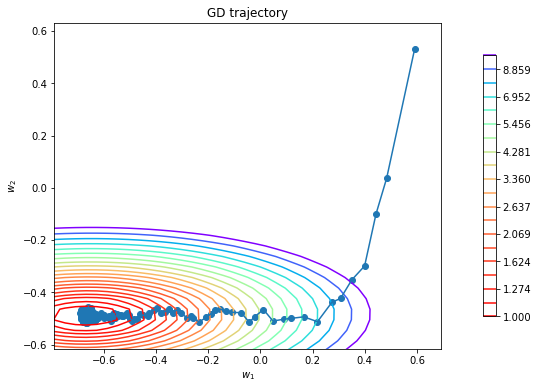

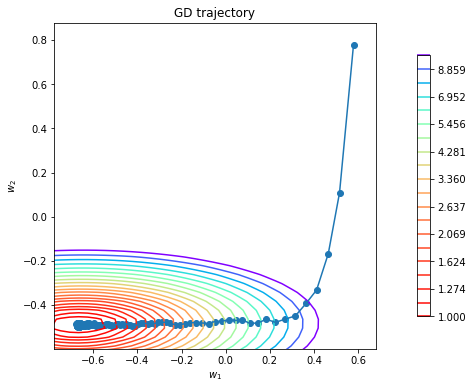

In [1561]:
# -- YOUR CODE HERE --
plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.01, 2,1000),X,y,loss)
plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.0001, 2,1000),X,y,loss)
plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.001, 10,1000),X,y,loss)
plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.0002, 10,1000),X,y,loss)
plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.003, 32,1000),X,y,loss)
plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.003, 150,1000),X,y,loss)

# при слишком маленьком batch и неправильным lr мы можем воодще не найти минимум
# но если взять подходящий lr(в нашем случае более маленький) это становится возможным

# при одинаковом batch, мы видим, что чем меньше lr в пределах(0.0001 до 0.1) тем меньше скачет наш градиентны спуск
# и мы более гладко приходим в точку минимума, но и для достижения области минимума потребуется больше итераций(шагов)

# также при одинаковом lr, чем больше batch тем меньше скачет наш градиентны спуск и более гладко приходим в точку минимума


# Как отличается поведение стохастического градиентного спуска от обычного?
# Многое зависит от параметров, но по картинкам можно заметить, что при стохастический градиентный спуске
# больше колебаний и нахождение точки минимума происходит не так гладко



Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [1562]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    # -- YOUR CODE HERE --
            
    new_w = w_init
    w_list = [] # список где будут хранится все наши веса
    lr_prew = lr
    for i in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False) # генерируем случ. индексы
        batch = X[batch_indices] # делаем выборку по наши индексам
        previous_w = new_w
        gradient = loss.calc_grad(batch, y[batch_indices], previous_w) # считаем градиент
        new_w = previous_w - lr*gradient # обновляем веса
        lr = lr_prew*((1/(1+i))**p) # уменьшаем длину шага 
        w_list.append(new_w)
        
    return np.asarray(w_list)
    

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

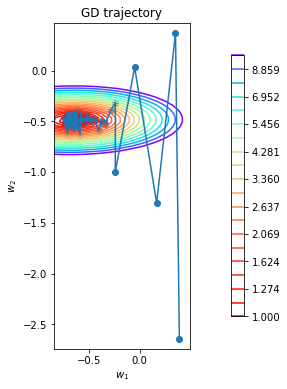

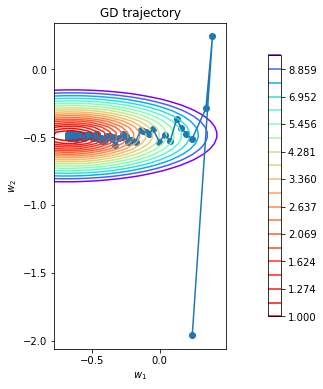

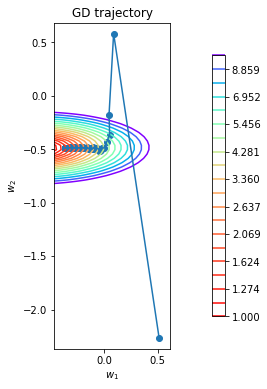

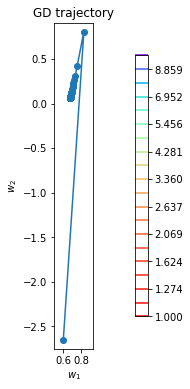

In [1565]:
# -- YOUR CODE HERE -- # c увели p шаг уменьшается
# plot_gd(stochastic_gradient_descent(w_init, X, y, 
#                         loss, 0.01, 10, 0.01),X,y,loss)

plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.01, 10,0.1),X,y,loss)
plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.01, 10,0.5),X,y,loss)
plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.01, 10,1.0),X,y,loss)
plot_gd(stochastic_gradient_descent(w_init, X, y, 
                        loss, 0.01, 10,2),X,y,loss)
# при маленьком значение p у нас делаются большие шаги сначала и мы быстрее попадаем в область, где расположен минимум

# при маленьких p шаги не так быстро уменьшаются, поэтому мы делаем изначально большое количесвто больших(длинных) шагов,
# чем больше p тем меньше больших шагов в начале мы делаем

# при слишком больших p мы сначала делаем большие шаги, а потом слишком рано и резко замедляемся
# и потом будем делать всё меньше и меньше шаги так и не дойдя до минимума

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

0.8670644395649493
1.5727405087008004


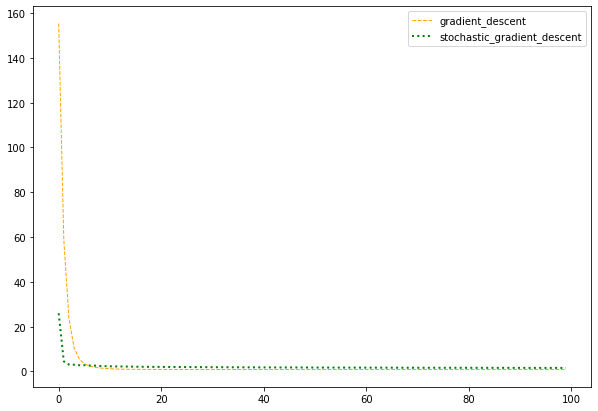

In [1643]:
# -- YOUR CODE HERE --
loss = MSELoss()
w_list1 = gradient_descent(w_init, X, y, loss, 0.01,100)
w_list2 =  stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10,1.0,100)

all_loss1 = []
all_loss2 = [] 
for i in range(len(w_list1)):
    all_loss1.append((loss.calc_loss(X, y, w_list1[i])))
    all_loss2.append((loss.calc_loss(X, y, w_list2[i])))

x1=np.arange(0., len(w_list1))
x2=np.arange(0., len(w_list2))

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(x1, all_loss1, color='orange', linewidth=1, linestyle='--',label = 'gradient_descent')
l, = ax.plot(x2, all_loss2, color='g', linewidth=2,linestyle=':',label = 'stochastic_gradient_descent')
ax.legend()
l.set_linestyle(':');
print(all_loss1[-1])
print(all_loss2[-1])

# Стохостический градиентный спуск сходится быстрее, чем обычный
# в случае стохастического градиентного спуска мы обновляем параметры для небольшой нашей выборки (батча)
# а затем вычисляет градиент, что делает его намного быстрее чем обычный gradient_descent


## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [1644]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        # -- YOUR CODE HERE --
        w_list = np.random.normal(size=(X.shape[1], ))  # инициализируем веса
        self.w = gradient_descent(w_list, X, y, self.loss, self.lr) # подбираем веса
        self.w = self.w[-1] # сохраняем последние веса
        
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        
        # -- YOUR CODE HERE --
        Y = np.dot(X,self.w) # делаем предсказание
        return Y

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [1645]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [1646]:
import pandas as pd

X_raw = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data', 
    header=None, 
    na_values=["?"]
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [1647]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [1648]:
X_raw

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
197,201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
198,202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
199,203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [1649]:
X_raw = X_raw.drop("index", axis=1) # удалим столбик index так как он не нужен и может только хуже повлиять на предсказание


In [1650]:
X_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22


In [1651]:
X_raw.isnull().sum()

0      0
1     37
2      0
3      0
4      0
5      2
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     4
19     4
20     0
21     2
22     2
23     0
24     0
dtype: int64

In [1652]:
from sklearn.impute import SimpleImputer

In [1654]:
# взято из 8 семинара
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
# категориальные признаки имеют тип "object"

cat_features_mask = (X_raw.dtypes == "object").values  # делаем булеву маску, чтобы выбрать столбцы с типом object 

# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]] # берём столбцы с int и float c помощью отрицания от cat_features_mask
X_no_mis_real = pd.DataFrame(data=SimpleImputer(strategy="mean").fit_transform(X_real), columns=X_real.columns) # заполняем пропуски средним

# для категориальных - пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("") # заполняем категориальные пустыми строками
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1) # соединяем категориальные и числовые в одно единое

X_no_mis.head()

,0,1,9,10,11,12,13,16,18,19,...,2,3,4,5,6,7,8,14,15,17
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [1655]:
# взято из 8 семинара
from sklearn import preprocessing
# определяем min max scaler
normalizer = preprocessing.MinMaxScaler()
# изменяем наши данные
X_real_norm_np = normalizer.fit_transform(X_dum) 
X = pd.DataFrame(data=X_real_norm_np) 
X.head()

/Users/yulia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/yulia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.8,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.8,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [903]:
X.describe() # смотрим что max=1 min=0

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,...,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.568159,0.298429,0.355598,0.494045,0.477697,0.497222,0.414145,0.248587,0.564793,0.565192,...,0.004975,0.004975,0.019900,0.318408,0.014925,0.099502,0.004975,0.457711,0.044776,0.004975
std,0.250960,0.167520,0.176862,0.183913,0.179613,0.203985,0.200658,0.156781,0.191480,0.150499,...,0.070535,0.070535,0.140007,0.467022,0.121557,0.300083,0.070535,0.499452,0.207328,0.070535
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.188482,0.230321,0.383582,0.324786,0.350000,0.264158,0.139623,0.435714,0.495238,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.600000,0.298429,0.303207,0.479104,0.444444,0.525000,0.359193,0.222642,0.550000,0.580952,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.800000,0.376963,0.460641,0.632836,0.538462,0.641667,0.557797,0.301887,0.742857,0.638095,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1656]:
sum(X.isnull().sum()) # cмотрим что пропусков нет и всё обработалось верно

0

In [1658]:
# Разделите датасет на обучающую и тестовую выборку
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2) # на тест выделим 20% на train 80%
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((160, 65), (41, 65), (160,), (41,))

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [1707]:
# -- YOUR CODE HERE --
linear_regression = LinearRegression(MSELoss())
linear_regression.fit(X_train, y_train)  # обучаем на train
pred_train1 = linear_regression.predict(X_train) # предсказываем на train
pred_test1 = linear_regression.predict(X_test) # предсказываем на test

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [1710]:
from sklearn.metrics import mean_squared_error

# -- YOUR CODE HERE --

print(f'Train mean_squared_error {mean_squared_error(y_train, pred_train1, squared=False):.2f}')
print(f'Test mean_squared_error {mean_squared_error(y_test, pred_test1, squared=False):.2f}')

Train mean_squared_error 1634.86
Test mean_squared_error 2188.83


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [1702]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # -- YOUR CODE HERE --
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        y_pred = np.dot(X, w)
        w = w[:-1] # bias регуляризовать не нужно, поэтому убраем последний элемент 
        loss = np.mean((y_pred-y)**2) + self.coef*(np.dot(np.transpose(w),w))
        return loss
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE --
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        
        y_pred = np.dot(X, w)
        X = np.transpose(X)
        w[-1] = 0 # зануляем bias
        grad = 2/(y.size)*np.dot(X,(y_pred-y))+2*np.dot(self.coef,w)
        return grad
        

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [1703]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [1717]:
# -- YOUR CODE HERE --
linear_regression = LinearRegression(MSEL2Loss(0.1))
linear_regression.fit(X_train, y_train)
pred_train1 = linear_regression.predict(X_train)
pred_test1 = linear_regression.predict(X_test)

In [1718]:
from sklearn.metrics import mean_squared_error

# -- YOUR CODE HERE --
print(f'Train mean_squared_error {mean_squared_error(y_train, pred_train1, squared=False):.2f}')
print(f'Test mean_squared_error {mean_squared_error(y_test, pred_test1, squared=False):.2f}')
# для наглядности ещё возьмем ошибку r2_score которая в идеале стремится к 1
print(f'Train R2 {r2_score(y_train, pred_train1):.2f}')
print(f'Test R2 {r2_score(y_test, pred_test1):.2f}')

Train mean_squared_error 3190.70
Test mean_squared_error 3163.55
Train R2 0.85
Test R2 0.78


In [1720]:
linear_regression = LinearRegression(MSEL2Loss(0.2))
linear_regression.fit(X_train, y_train)
pred_train1 = linear_regression.predict(X_train)
pred_test1 = linear_regression.predict(X_test)
print(f'Train mean_squared_error {mean_squared_error(y_train, pred_train1, squared=False):.2f}')
print(f'Test mean_squared_error {mean_squared_error(y_test, pred_test1, squared=False):.2f}')
print(f'Train R2 {r2_score(y_train, pred_train1):.2f}')
print(f'Test R2 {r2_score(y_test, pred_test1):.2f}')
# видно что разника между Train и Test небольшая наша модель обучилась неплохо
# хорошо видно,если сравнивать полученые значения с теми, что в прошлом задание, что с регуляризацей
#наша модель не переобучается разница Train и Test не такая большая
# как если применять регрессию без регуляризации

Train mean_squared_error 3765.43
Test mean_squared_error 3452.01
Train R2 0.79
Test R2 0.74


В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [1724]:
import numpy.linalg as la

In [1726]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        # -- YOUR CODE HERE --
        # Вычислите значение функции потерь при помощи X, y и w и верните его
    
        if la.norm(y - np.dot(X,w)) <= self.eps:  # считаем норму верктора наших предсказаний сравниваем с self.eps и дальше разветвления в зависимости от результата 
                                                  #  и применение соответ. формул
            return 0.5 * la.norm(y -np.dot(X,w)) 
        else:
            return self.eps*la.norm((y - np.dot(X,w) - 0.5*self.eps) , ord = 1)
        
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE --
        # Вычислите значение вектора градиента при помощи X, y и w и верните его

            
        if (la.norm(y - np.dot(X,w))) <= self.eps:#  считаем норму верктора наших предсказаний сравниваем с self.eps и дальше разветвления в зависимости от результата 
                                                  #  и применение соответ. формул
            grad = np.dot(X.T, (np.dot(X,w) - y)) / y.shape[0]
        else:
            grad =  self.eps *np.dot(X.T, np.sign(np.dot(X,w) - y))/ y.shape[0]
            

        return grad

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [1728]:
# -- YOUR CODE HERE --
linear_regression = LinearRegression(HuberLoss(1.0))
linear_regression.fit(X_train, y_train)
pred_train1 = linear_regression.predict(X_train)
pred_test1 = linear_regression.predict(X_test)


print(mean_squared_error(y_train, pred_train1, squared=False))
print(mean_squared_error(y_test, pred_test1, squared=False))
print(f'Train R2 {r2_score(y_train, pred_train1):.2f}')
print(f'Test R2 {r2_score(y_test, pred_test1):.2f}')
# у нашей модели не получается обучиться слишком большие ошибки и на Train и на Test

15040.725895823314
13692.437814864636
Train R2 -2.36
Test R2 -3.17
